In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brindhaganesh","key":"f9cc507362148240f8e7ab85dc6c89f4"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install kaggle


In [ ]:
#!kaggle datasets download -d zahidmughal2343/global-cancer-patients-2015-2024


Dataset URL: https://www.kaggle.com/datasets/zahidmughal2343/global-cancer-patients-2015-2024
License(s): CC-BY-NC-SA-4.0


In [4]:
!kaggle datasets download -d thilak02/breast-cancer-detection-using-thermography


Dataset URL: https://www.kaggle.com/datasets/thilak02/breast-cancer-detection-using-thermography
License(s): MIT


In [5]:
import zipfile

with zipfile.ZipFile('breast-cancer-detection-using-thermography.zip', 'r') as zip_ref:
    zip_ref.extractall('Breast_cancer')


In [9]:
base_path = "./Breast_cancer/BCD_Dataset"
label_categories = ['Sick','Unknown_class','normal']

In [10]:
image_paths = []
labels = []

In [11]:
import os
for i in label_categories:
  path = os.path.join(base_path,i)
  for img in os.listdir(path):
    image_paths.append(os.path.join(path,img))
    labels.append(i)

In [13]:
import pandas as pd
df = pd.DataFrame()
df['image_paths'] = image_paths
df['labels'] = labels

In [14]:
df.head()

,image_paths,labels
0,./Breast_cancer/BCD_Dataset/Sick/T0181.1.1.S.2...,Sick
1,./Breast_cancer/BCD_Dataset/Sick/T0342.1.1.S.2...,Sick
2,./Breast_cancer/BCD_Dataset/Sick/T0346.1.1.D.2...,Sick
3,./Breast_cancer/BCD_Dataset/Sick/T0263.1.1.S.2...,Sick
4,./Breast_cancer/BCD_Dataset/Sick/T0408.1.1.S.2...,Sick


## Data quality check

In [15]:
print(f'no_of_duplicates :',{df.duplicated().sum()})
print(df.info())

no_of_duplicates : {np.int64(0)}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_paths  362 non-null    object
 1   labels       362 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB
None


## Data distribution check


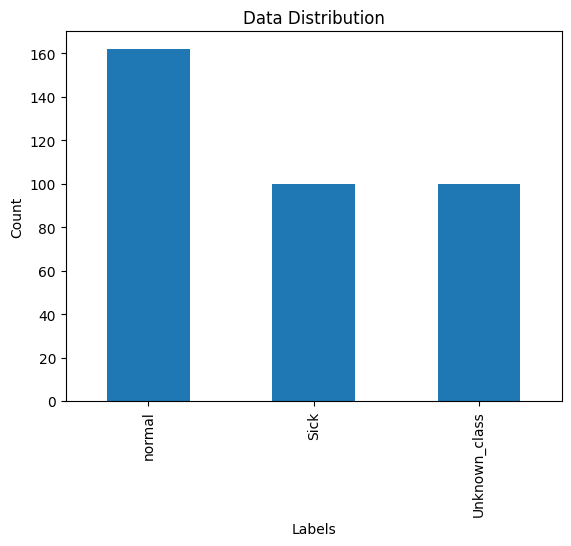

In [16]:
import matplotlib.pyplot as plt

df['labels'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [77]:
print(df['labels'].value_counts())


labels
normal           162
Sick             100
Unknown_class    100
Name: count, dtype: int64


The dataset is small and it is imbalanced.

we will plot sample images for each class and their shape

Class: Sick
Shape: (120, 160, 3)
Pixel Value Range: [0, 255]
Data Type: uint8
--------------------------------------------------
Class: Unknown_class
Shape: (64, 64, 3)
Pixel Value Range: [0, 227]
Data Type: uint8
--------------------------------------------------
Class: normal
Shape: (120, 160, 3)
Pixel Value Range: [0, 255]
Data Type: uint8
--------------------------------------------------


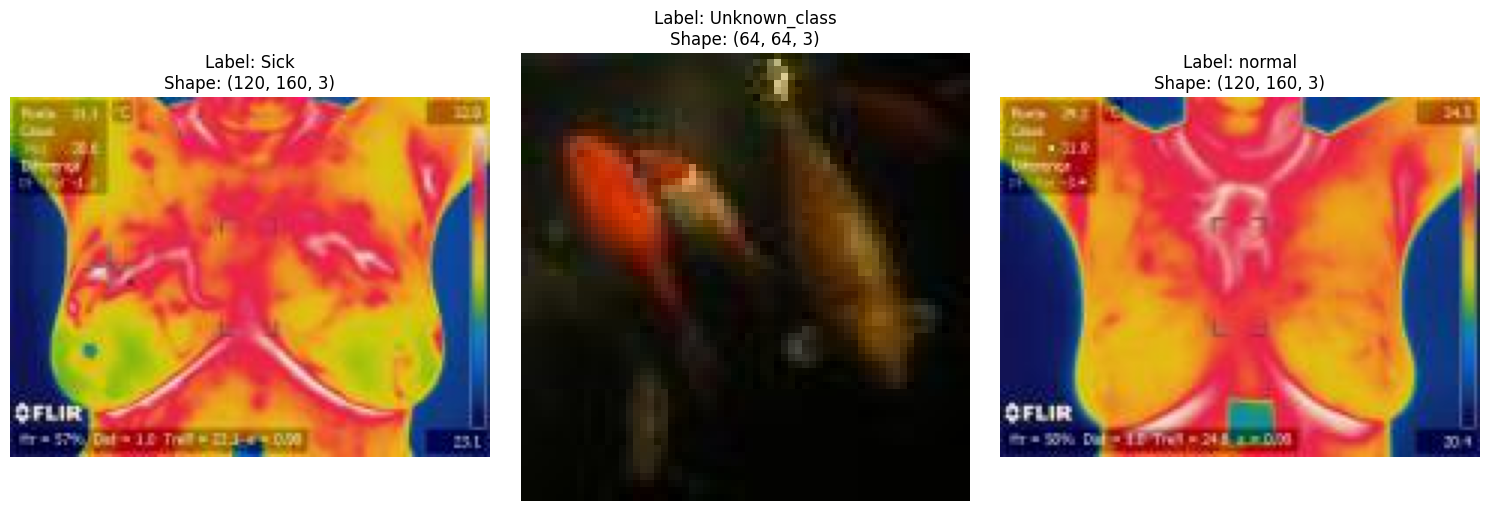

In [78]:
from PIL import Image
import numpy as np

# Select one image per class
sample_images = df.groupby('labels').first().reset_index()

# Plot images
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for idx, row in sample_images.iterrows():
    img_path = row['image_paths']
    label = row['labels']
    img = Image.open(img_path)
    img_array = np.array(img)

    axes[idx].imshow(img)
    axes[idx].set_title(f"Label: {label}\nShape: {img_array.shape}")
    axes[idx].axis('off')

    # Print image properties
    print(f"Class: {label}")
    print(f"Shape: {img_array.shape}")
    print(f"Pixel Value Range: [{img_array.min()}, {img_array.max()}]")
    print(f"Data Type: {img_array.dtype}")
    print("-" * 50)

plt.tight_layout()
plt.show()

checking image shapes for each class

In [17]:
import pandas as pd
import numpy as np
from PIL import Image

# Function to get image shape
def get_image_shape(img_path):
    try:
        img = Image.open(img_path)
        img_array = np.array(img)
        return img_array.shape
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

# Add a column for shapes
df['shape'] = df['image_paths'].apply(get_image_shape)

# Filter out any failed loads
df = df.dropna(subset=['shape'])

# Summarize shapes by class
shape_summary = df.groupby('labels')['shape'].value_counts()
print("Shape distribution by class:")
print(shape_summary)

# Check unique shapes per class
unique_shapes_by_class = df.groupby('labels')['shape'].apply(lambda x: set(map(str, x)))
print("\nUnique shapes by class:")
for label, shapes in unique_shapes_by_class.items():
    print(f"{label}: {shapes}")

Shape distribution by class:
labels         shape        
Sick           (120, 160, 3)    100
Unknown_class  (64, 64, 3)      100
normal         (120, 160, 3)    162
Name: count, dtype: int64

Unique shapes by class:
Sick: {'(120, 160, 3)'}
Unknown_class: {'(64, 64, 3)'}
normal: {'(120, 160, 3)'}


One hot encoding for categorical lables

In [18]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['encoded_labels'] = encoder.fit_transform(df['labels'])
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

{'Sick': np.int64(0), 'Unknown_class': np.int64(1), 'normal': np.int64(2)}


This dataset is imbalanced and normal class is overrepresented. The model may bias toward predicting "normal". there are different ways to handle the imbalance. First we try with oversampling method:Here we duplicate the minority class count to match the Normal class count

In [19]:
from sklearn.utils import resample

majority_class_size = df['labels'].value_counts().max()
df_balanced = (df.groupby('labels', group_keys=False)
               .apply(lambda x: resample(x,
                                        replace=True,
                                        n_samples=majority_class_size,
                                        random_state=42)))
print(df_balanced['labels'].value_counts())


labels
Sick             162
Unknown_class    162
normal           162
Name: count, dtype: int64


<ipython-input-19-715394695e32>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: resample(x,


In [20]:
df_balanced.reset_index(drop=True, inplace=True)
df_balanced.head()

,image_paths,labels,shape,encoded_labels
0,./Breast_cancer/BCD_Dataset/Sick/T0398.1.1.S.2...,Sick,"(120, 160, 3)",0
1,./Breast_cancer/BCD_Dataset/Sick/T0213.1.1.S.2...,Sick,"(120, 160, 3)",0
2,./Breast_cancer/BCD_Dataset/Sick/T0258.1.1.S.2...,Sick,"(120, 160, 3)",0
3,./Breast_cancer/BCD_Dataset/Sick/T0277.1.1.S.2...,Sick,"(120, 160, 3)",0
4,./Breast_cancer/BCD_Dataset/Sick/T0422.1.1.S.2...,Sick,"(120, 160, 3)",0


In [21]:
from sklearn.model_selection import train_test_split

# Split into train+val and test
train_val_df, test_df = train_test_split(
    df_balanced,
    test_size=0.1,  # 10% for test
    stratify=df_balanced['encoded_labels'],
    random_state=42
)

# Split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.222,  # 20% of 90% = 18% of total
    stratify=train_val_df['encoded_labels'],
    random_state=42
)


print("Train distribution:\n", train_df['encoded_labels'].value_counts())
print("Validation distribution:\n", val_df['encoded_labels'].value_counts())
print("Test distribution:\n", test_df['encoded_labels'].value_counts())

Train distribution:
 encoded_labels
1    113
2    113
0    113
Name: count, dtype: int64
Validation distribution:
 encoded_labels
1    33
0    33
2    32
Name: count, dtype: int64
Test distribution:
 encoded_labels
2    17
0    16
1    16
Name: count, dtype: int64


In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='checkpoint.pth'):
        """
        Args:
            patience (int): Number of epochs to wait for improvement.
            min_delta (float): Minimum change in monitored metric to qualify as improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Check if validation loss improved
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [23]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_paths']
        label = self.dataframe.iloc[idx]['encoded_labels']
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, label

In [24]:
# Training transformations (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for model input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/test transformations (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df, transform=val_test_transform)
test_dataset = ImageDataset(test_df, transform=val_test_transform)

In [26]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Pretrained model is used.

In [61]:
def get_model(model_name, num_classes=3):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        lr = 0.0001
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        lr = 0.001
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        lr = 0.001
    elif model_name == "mobilenet_v3_small":
        model = models.mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        lr = 0.001
    elif model_name == "vit_b_16":
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
        lr = 0.0001
    else:
        raise ValueError(f"Model {model_name} not supported.")
    return model, lr

In [68]:
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet18
#model = models.resnet18(pretrained=True)
#model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 3)  # 3 classes

model_name = "resnet50"
model, lr = get_model(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.0001) # Lowering the lr for big models
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch 1/50, Train Loss: 0.4897, Val Loss: 0.2126, Val Accuracy: 89.80%
Saved best model with Val Loss: 0.2126
Epoch 2/50, Train Loss: 0.1559, Val Loss: 0.1864, Val Accuracy: 89.80%
Saved best model with Val Loss: 0.1864
Epoch 3/50, Train Loss: 0.0836, Val Loss: 0.1157, Val Accuracy: 93.88%
Saved best model with Val Loss: 0.1157
Epoch 4/50, Train Loss: 0.0623, Val Loss: 0.1546, Val Accuracy: 93.88%
No improvement, patience counter: 1/5
Epoch 5/50, Train Loss: 0.0550, Val Loss: 0.0834, Val Accuracy: 95.92%
Saved best model with Val Loss: 0.0834
Epoch 6/50, Train Loss: 0.0224, Val Loss: 0.1665, Val Accuracy: 96.94%
No improvement, patience counter: 1/5
Epoch 7/50, Train Loss: 0.0332, Val Loss: 0.1108, Val Accuracy: 95.92%
No improvement, patience counter: 2/5
Epoch 8/50, Train Loss: 0.0128, Val Loss: 0.1708, Val Accuracy: 94.90%
No improvement, patience counter: 3/5
Epoch 9/50, Train Loss: 0.0133, Val Loss: 0.1317, Val Accuracy: 94.90%
No improvement, patience counter: 4/5
Epoch 10/50, Tr

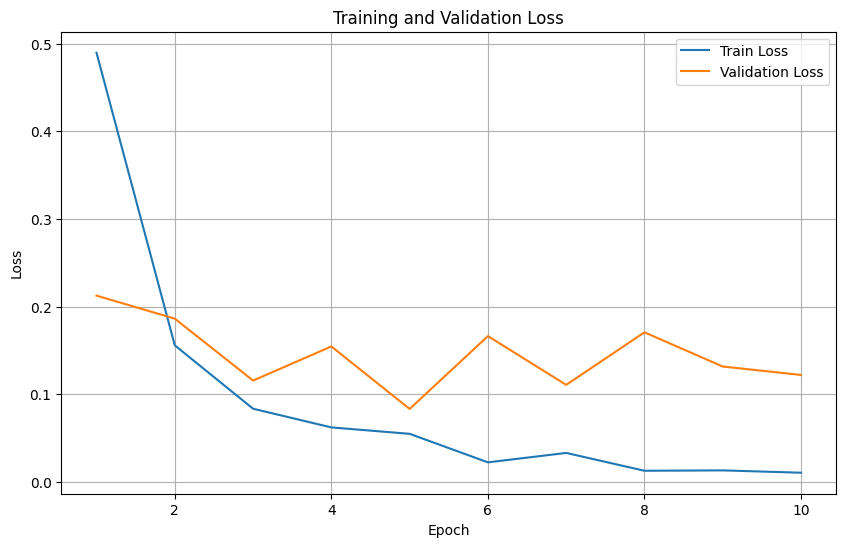

In [71]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement, patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')

    return train_losses, val_losses, best_model_path

# Train
train_losses, val_losses, best_model_path = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

In [72]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_model(model, test_loader)

Test Accuracy: 100.00%


100.0

Notes based on tuning hyperparameters:
resnet18 : Changing the rotation from 10 to 5 decreased the performance of the model from 93% to 79%


plotting confusion matrix to have complete picture of model errors


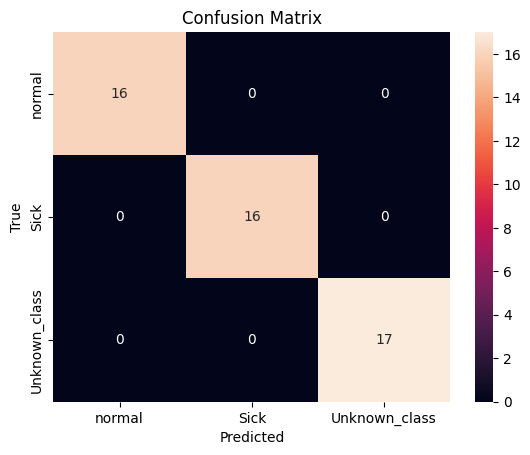

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
class_names = ['normal', 'Sick', 'Unknown_class']
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [74]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['normal', 'Sick', 'Unknown_class']))

Classification Report:
                precision    recall  f1-score   support

       normal       1.00      1.00      1.00        16
         Sick       1.00      1.00      1.00        16
Unknown_class       1.00      1.00      1.00        17

     accuracy                           1.00        49
    macro avg       1.00      1.00      1.00        49
 weighted avg       1.00      1.00      1.00        49



#### Precision = Precision = True Positives (TP) / (True Positives + False Positives)for resnet18 Both confusion matrix and classification report tells that precision of sick and unknown class are 100% correct and there are no false positives but the model has predicted normal when the image class doesnt belong to normal(false positive) and hence normal class has decreased precision score

#### Recall = True Positives (TP) / (True Positives + False Negatives) explains about false negatives. That is why we have unknown class score is < 1 for resnet18 model, the model failed to identify 2 samples belonged to unknown class. In any medical related application Recall score is important.

#### f1 score = 2 * (Precision * Recall) / (Precision + Recall). this score gives a balanced overview when we need to consider both false positives and false negatives

#### accuracy = (Total Correct Predictions) / (Total Samples)

